# True Zonal Mean

Calculate the *true zonal mean* of a scalar quantity regardless of the horizontal mesh. 


In [1]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38033,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38659,Total threads: 1
Dashboard: /proxy/37679/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36057,


First we show the standard approach, which is to take the arithmetic mean of all grid cells along the quasi-longitudinal coordinate. For MOM5's tri-polar grid this approach is in principle "okay" for the southern hemisphere, where grid cell areas are constant at fixed latitude. It doesn't though, take into account partial cells.

The `xarray`'s method `.mean(dim='dimension')` applies `numpy.mean()` across that dimension. This is simply the arithmetic mean.

For some scalar $T$ the arithmetic mean, e.g., across dimension `i`, is given by

$$ \left<T\right>_{j,k} = \frac{1}{I}\sum_{i=1}^{I} T_{i,j,k},$$

where $i$, $j$ and $k$ are the indicies in the $x$, $y$ and $z$ directions respectively of the curvilinear grid and $I$ is the number of indicies along the $x$ axis. 

In [3]:
import os
# Set an environment variable
os.environ['ESMVALTOOL_CONFIG_DIR'] = '/home/189/fc6164/esmValTool'
print(os.environ['ESMVALTOOL_CONFIG_DIR'])
from esmvalcore.dataset import Dataset

/home/189/fc6164/esmValTool


In [ ]:
## arith mean - climate statistics, zonal statistics
import iris
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import zonal_statistics
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import histogram
import numpy as np

from esmvalcore.dataset import Dataset
import iris.plot as iplt
import matplotlib.pyplot as plt

In [ ]:
## sea water conservative temperature
model_OM2 = Dataset(short_name='bigthetao', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0316/0366",
    dataset="ACCESS-OM2", grid="gn") #-025

model_OM2.add_supplementary(short_name="volcello", mip="Ofx") #load later

In [5]:

cb = climate_statistics(model_OM2.load(), period='full',operator='mean')
# dimensions are cell indexes along first and second dimension
cb = regrid(cb, '1x1', 'linear') # regrided to lat/lon, losing cell measure
cb = zonal_statistics(cb, operator='mean') #

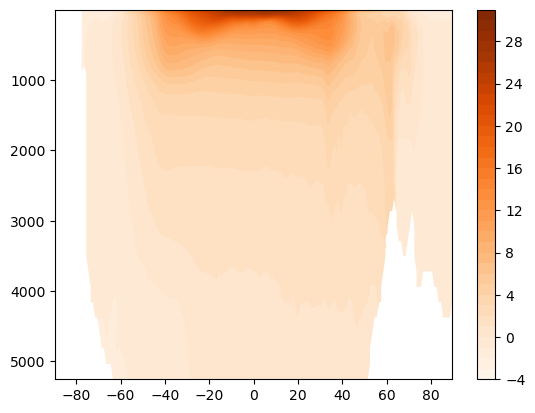

In [35]:
# quick plot result
iplt.contourf(cb, levels=np.arange(-4,32,1), cmap='Oranges')
plt.colorbar()
plt.show()

The main issue with this average is that the 'latitude' coordinate may be meaningless near the north pole, particularly when comparing to observational analyses or other models which can have either a regular grid or a different curvilinear grid. Even different versions of MOM might have different grids! 

Let us consider what the true zonal average looks like. That is consider a set of latitude 'edges' $\{\phi'_{1/2},\phi'_{1+1/2},...,\phi'_{\ell-1/2},\phi'_{\ell+1/2},...,\phi'_{L+1/2}\}$ between which we want to compute an average of $T$ at $\{\phi'_{1},\phi'_{2},...,\phi'_{\ell},...,\phi'_{L}\}$ such that

$$ \overline{T}(\phi'_\ell,\sigma) = \dfrac{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}} T(\phi,\lambda,\sigma)\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A}{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}}\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A},$$

where $\lambda$ is longitude and $\sigma$ is an arbitrary vertical coordinate. 

In discrete form this average is

$$\overline{T}_{\ell,k} = \frac{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j}T_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}},$$

where $\delta_{i,j} = 1$ if $\phi'_{\ell-1/2}<\phi_{i,j}\leq \phi'_{\ell+1/2}$ and $\delta_{i,j} = 0$ elsewhere, $\Delta Z$ is the grid cell vertical thickness and $\Delta \mathrm{Area}$ is the grid cell horizontal area.

For our purposes we will use the edges of the models `xt_ocean` coordinate to define $\phi'_{\ell+1/2}$ so the number of 'bins' $L$ will be the same as the length of the quasi-latitude coordinate ($J$). 

Fortunately, as you can see below, the two sums are weighted histograms (one for $T$ times volume and the other for just volume) and these can be rapidly computed using preprocessor function `histogram`.

First lets load the scalar variable (latitude) we want to use as our coordinate then define the bin edges.

Now we want to define the coordinate bins as the latitude edges of the t-cells, adding the first edge (0) at latitude -90:

In [14]:
# load dataset again and calulate full time mean
ldcb = model_OM2.load()
cbtmean = climate_statistics(ldcb, period='full',operator='mean')
# load associated cell volume supplementary variable as cube
volcb = model_OM2.supplementaries[0].load() #supplementaries gives list

# inspect data
print(ldcb.summary(shorten=True), "\nall coords:")
for coord in ldcb.coords():
    print(coord.summary(shorten=True))

sea_water_conservative_temperature / (degC) (time: 612; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360) 
all coords:
<DimCoord: time / (days since 1850-1-1 00:00:00)  [...]+bounds  shape(612,)>
<DimCoord: depth / (m)  [1.152e+00, 3.649e+00, ..., 5.034e+03, 5.254e+03]+bounds  shape(50,)>
<DimCoord: cell index along second dimension / (1)  [ 0, 1, ..., 298, 299]  shape(300,)>
<DimCoord: cell index along first dimension / (1)  [ 0, 1, ..., 358, 359]  shape(360,)>
<AuxCoord: latitude / (degrees_north)  <lazy>+bounds  shape(300, 360)>
<AuxCoord: longitude / (degrees_east)  <lazy>+bounds  shape(300, 360)>


In [19]:
#latitude multidimensional coordinate second last in list
geolat = ldcb.coords()[-2].points 
stacked = np.tile(geolat, (50, 1, 1)) # depth shape is 50
stacked.mask = volcb.data.mask #use mask for invalid cells from volume

print(stacked.shape)
print(ldcb.coord(var_name = 'i')) # check for dimensional coordinates in new cube

# create cube of latitude as variable to create histogram
cube = iris.cube.Cube(stacked, long_name='latitude', units=ldcb.coords()[-2].units,
               dim_coords_and_dims=[(ldcb.coord(var_name='j'), 1), #var_name i,j
                                   (ldcb.coord(var_name='i'), 2),
                                   (ldcb.coord('depth'),0)])

(50, 300, 360)
DimCoord :  cell index along first dimension / (1)
    points: [  0,   1, ..., 358, 359]
    shape: (360,)
    dtype: int32
    long_name: 'cell index along first dimension'
    var_name: 'i'


Now let's compute the numerator and denominator of the equation above using `histogram`, then the zonal mean.

In [21]:
# bins to be 181 -latitude 1deg or regridding size used before for comparison
hdeg_bins=np.linspace(-90, 90, 181)

histvol = histogram(cube, bins=hdeg_bins, coords=[cube.coords()[1], cube.coords()[2]], weights=volcb.data)
hist_tempvol = histogram(cube, bins=hdeg_bins, coords=[cube.coords()[1], cube.coords()[2]], weights=volcb.data*cbtmean.data)

cube_out = hist_tempvol / histvol
cube_out.long_name = 'True Zonal Mean'

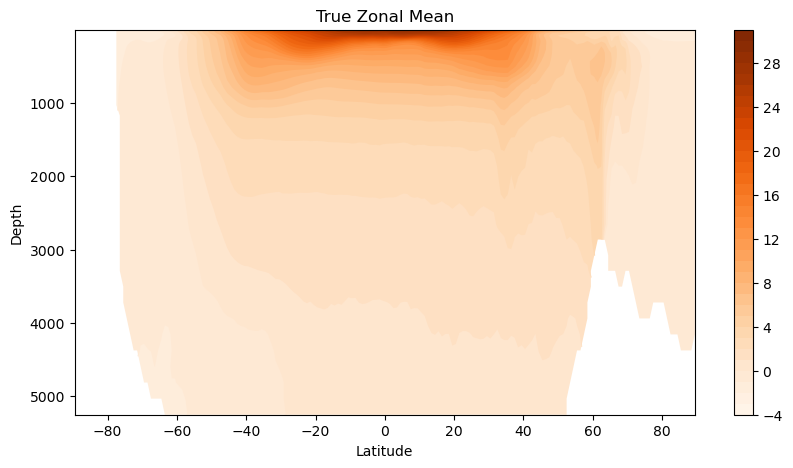

In [36]:
# plot
plt.figure(figsize=(10,5))
iplt.contourf(cube_out, levels=np.arange(-4,32,1), cmap='Oranges')
plt.title('True Zonal Mean')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.colorbar(label='Degrees C')
plt.show()

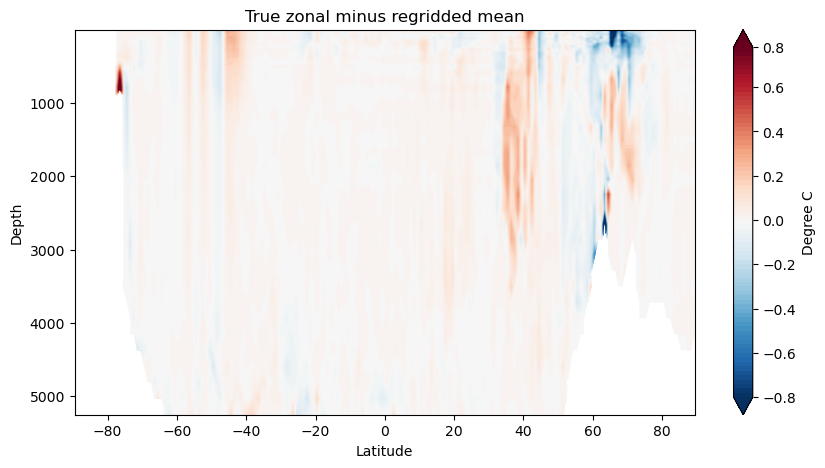

In [37]:
# zonal_minus_x_mean

cube_out.units = "degC"
diff = cube_out - cb
plt.figure(figsize=(10,5))
iplt.contourf(diff, levels=np.arange(-0.8, 0.8, 0.02), cmap='RdBu_r', extend='both')
plt.title('True zonal minus regridded mean')
plt.colorbar(label='Degrees C', ticks=np.arange(-0.8, 0.9, 0.2))
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.show()

Since we used the same bin edges as the standard `yt_ocean` coordinate we can take a difference between the arithmetic mean along the model's x-axis and our mean along grid cells within latitude bands. The main differences are near the North Pole where the grid is furthest for being regular. There are also differences near the Antacrtic Shelf suggesting partial cells also matter.

In [ ]:
client.close()